#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

План:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders`

In [1]:
#!pip install catboost

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection  import train_test_split, cross_val_score, TimeSeriesSplit, RandomizedSearchCV, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error as MSE

## Подготовка

План:
1. загрузить данные
2. отсортировать и проверить монотонность временного ряда
3. ресемплировать до 1 часа

In [3]:
# загрузка, просмотр информации, сортировка индекса, проверка монотонности, просмотр первых и последних строк
df = pd.read_csv('f:/yandex-practicum/datasets/taxi.csv', index_col=[0],parse_dates=[0])
df.info()
df.sort_index(inplace=True)
print('Данные монотонны:', df.index.is_monotonic)
df

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
Данные монотонны: True


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [4]:
# ресемплирование до 1 часа
df = df.resample('1H').sum()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


### Вывод
1. данные загружены
2. отсортированы и проверена монотонность временного ряда
3. ресемплированы до 1 часа суммированием

## Анализ
План:
1. Построение графиков временного ряда
2. Декомпозиция на тренд и сезонность
3. Анализ временного ряда

<AxesSubplot:title={'center':'num_orders_2week_data'}, xlabel='datetime'>

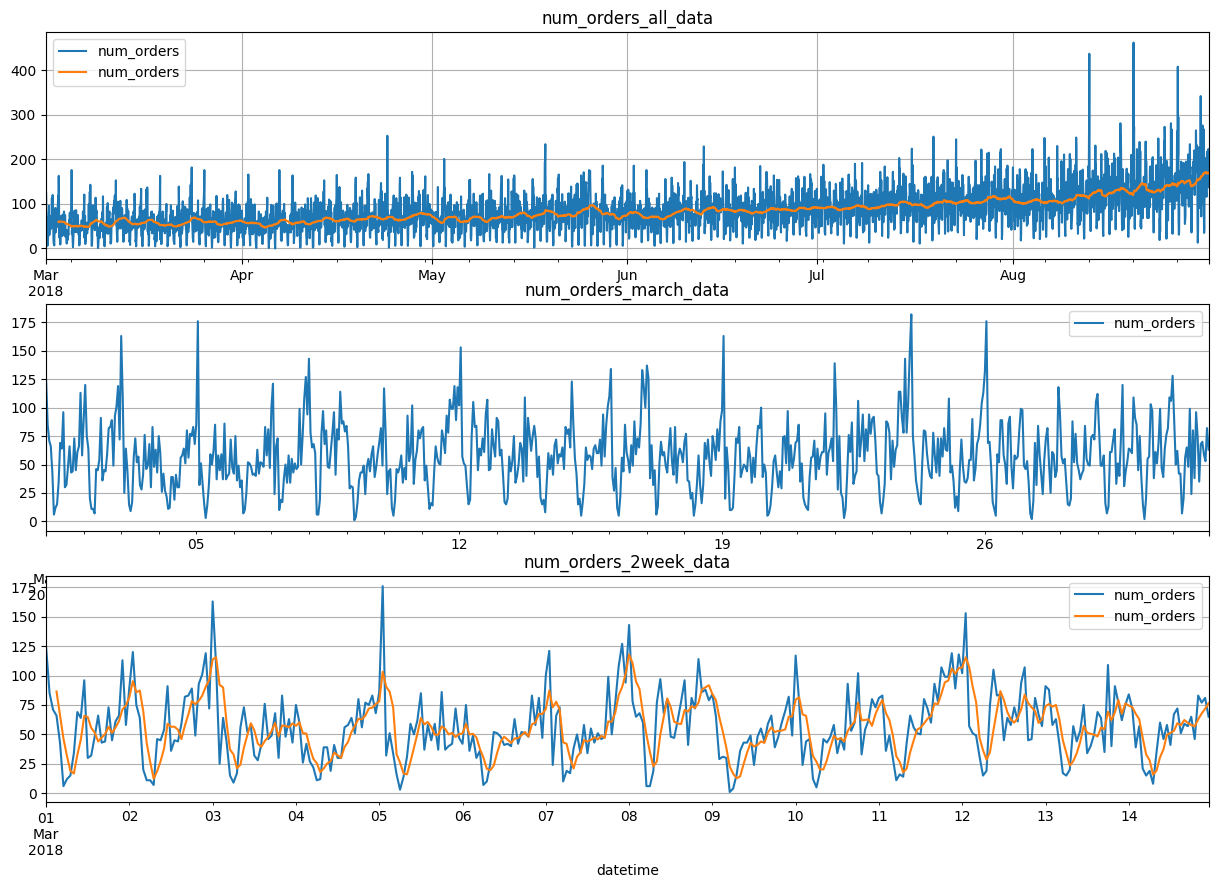

In [5]:
# Просмотр временнного ряда в разных масштабах
plt.figure(figsize=(15,10))
plt.subplot(311)
df.plot(ax=plt.gca())
df.rolling(48).mean().plot(ax=plt.gca(), title='num_orders_all_data', grid=True)


plt.subplot(312)
df['2018-03':'2018-03'].plot(ax=plt.gca(), title='num_orders_march_data', grid=True)

plt.subplot(313)
df['2018-03-01':'2018-03-14'].plot(ax=plt.gca())
df['2018-03-01':'2018-03-14'].rolling(4).mean().plot(ax=plt.gca(), title='num_orders_2week_data', grid=True)


<AxesSubplot:title={'center':'Residial'}, xlabel='datetime'>

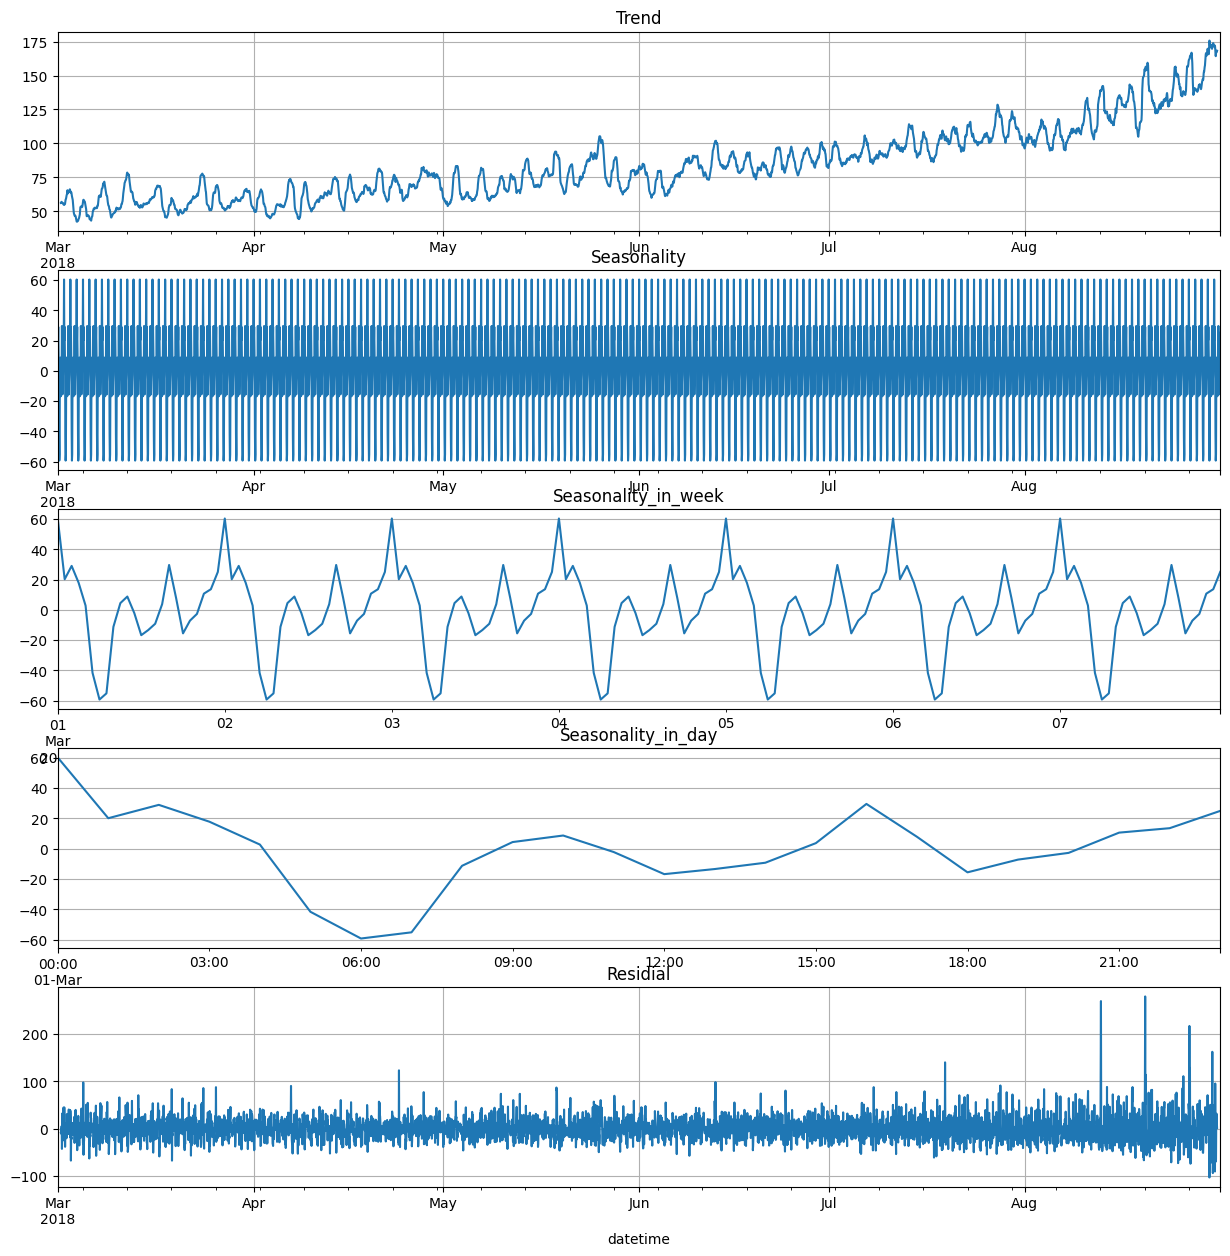

In [6]:
# Просмотр тренда, сезонности и шумов
decomposed = seasonal_decompose(df)

plt.figure(figsize=(15,15))

plt.subplot(511)
decomposed.trend.plot(ax=plt.gca(), title='Trend', grid=True)

plt.subplot(512)
decomposed.seasonal.plot(ax=plt.gca(), title='Seasonality')

plt.subplot(513)
decomposed.seasonal['2018-03-01':'2018-03-07'].plot(ax=plt.gca(), title='Seasonality_in_week', grid=True)

plt.subplot(514)
decomposed.seasonal['2018-03-01':'2018-03-01'].plot(ax=plt.gca(), title='Seasonality_in_day', grid=True)

plt.subplot(515)
decomposed.resid.plot(ax=plt.gca(), title='Residial', grid=True)


### Вывод
На полной выборке наблюдается тренд увеличения числа заказов с марта по август. В ночь с воскресенья на понедельник наблюдается внутринедельный максимум числа заказов. Внутридневной минимум заказов по утрам.

Временной ряд декомпозирован на тренд и сезонность. Графики подтверждают предыдущие выводы. 
Есть тренд роста числа заказов такси внутри года.
Есть внутридневная сезонность: в 6 утра число заказов минимально, в 12 ночи число заказов максимально.

## Обучение моделей
План:
1. Создание функции подготовки признаков, создание и анализ признаков.
2. Создание, обучение, проверка качества моделей

### Создание и анализ признаков

In [7]:
# функция подготовки признаков
def make_features(df, max_lag, rolling_mean_size):
    dff = df
    dff['month'] = df.index.month
    dff['day'] = df.index.day
    dff['dayofweek'] = df.index.dayofweek
    dff['hour'] = df.index.hour
    for i in range(max_lag):
        dff[f'lag_{i+1}'] = df['num_orders'].shift(i+1)
    dff['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    return dff.dropna()

In [8]:
df_ftrs = make_features(df, 2, 2)
df_ftrs.head()

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,rolling_mean
datetime,,,,,,,,
2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,104.5
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,78.0
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,68.5
2018-03-01 05:00:00,6,3,1,3,5,43.0,66.0,54.5
2018-03-01 06:00:00,12,3,1,3,6,6.0,43.0,24.5


num_orders      1.000000
month           0.510696
day             0.165771
dayofweek      -0.019630
hour            0.004630
lag_1           0.624190
lag_2           0.465444
rolling_mean    0.604753
Name: num_orders, dtype: float64


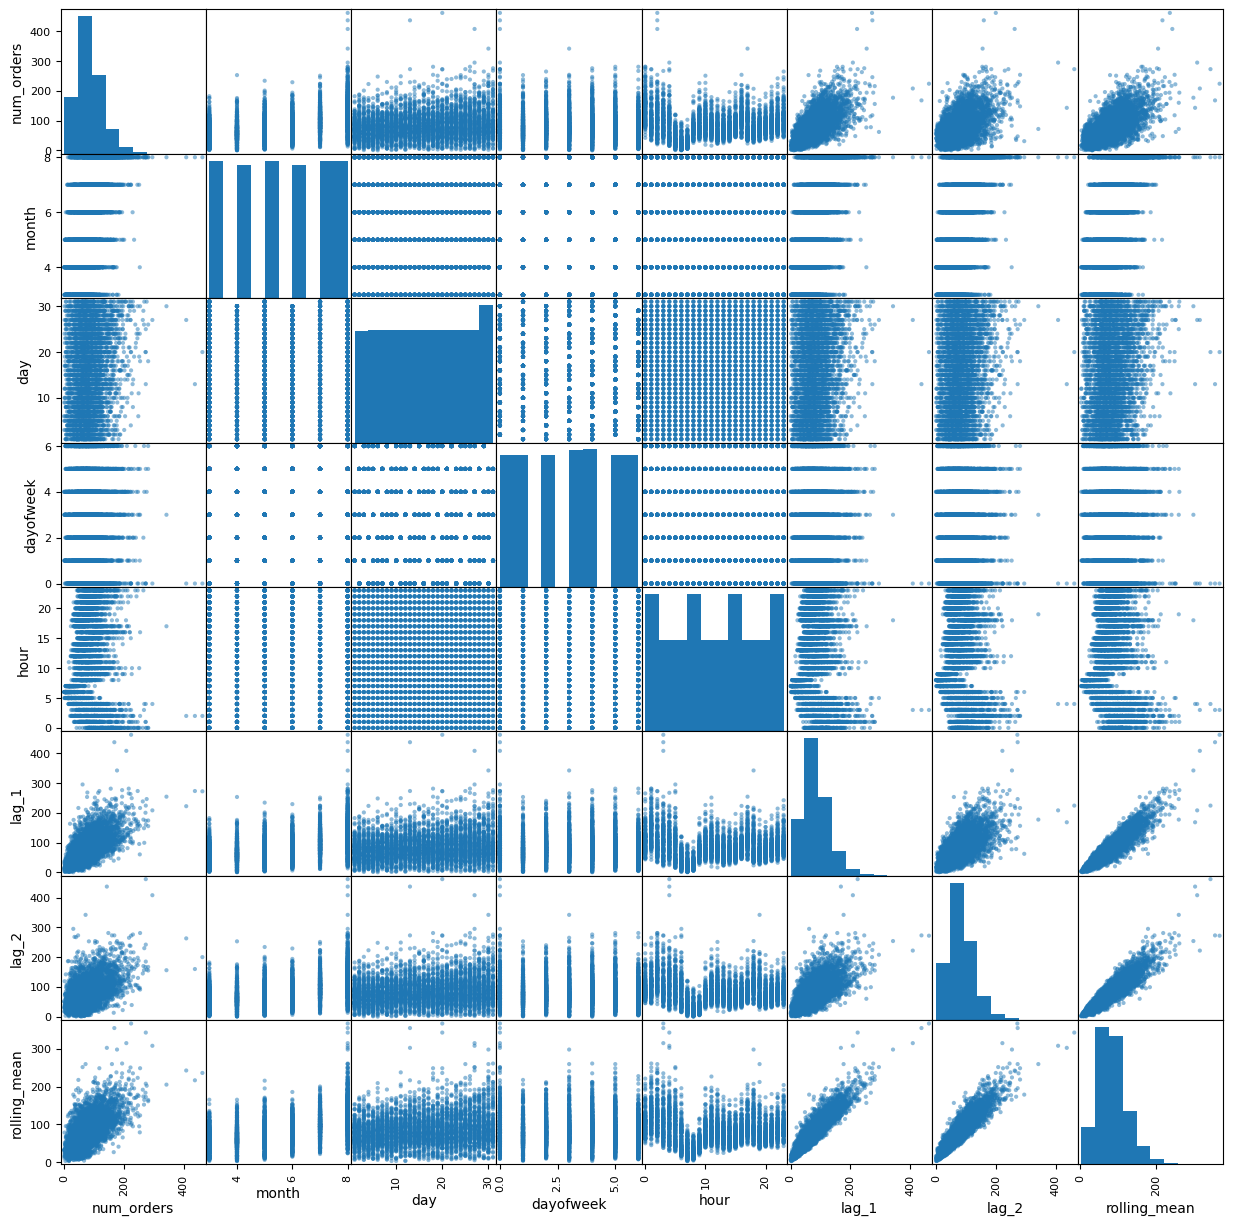

In [9]:
# расчет корреляции и матрицы рассеяния
print(df_ftrs.corr()['num_orders'])
pd.plotting.scatter_matrix(df_ftrs,figsize=(15,15))[0];

In [10]:
# разбивка на обучающую и тестовую выборки
train, test = train_test_split(df_ftrs,shuffle=False, test_size=0.1)

# Выделение признаков и целевого признака
features_train = train.drop('num_orders',axis=1) 
target_train = train['num_orders']
features_test = test.drop('num_orders',axis=1) 
target_test = test['num_orders']

### Создание и обучение моделей

In [11]:
model = {}
#(CatBoostRegressor, DecisionTreeRegressor, RandomForestRegressor, LinearRegression)

model['CBR'] = CatBoostRegressor(random_state=12345, silent=True)
model['DTR'] = DecisionTreeRegressor(random_state=12345)
model['RFR'] = RandomForestRegressor(random_state=12345)
model['LR'] = LinearRegression()

In [ ]:
# Метрики моделей при исключении признака день
for model_type in ['CBR','DTR','RFR','LR']:
    model[model_type].fit(features_train.drop('day', axis=1),target_train)
    print(f'RMSE модели {model_type} train: {MSE(target_train,model[model_type].predict(features_train.drop("day", axis=1)), squared=False):.2f}, test: {MSE(target_test,model[model_type].predict(features_test.drop("day", axis=1)), squared=False):.2f}\n')

RMSE модели CBR train: 15.68, test: 51.20

RMSE модели DTR train: 0.34, test: 59.51

RMSE модели RFR train: 8.51, test: 50.49

RMSE модели LR train: 30.78, test: 53.59



In [13]:
for model_type in ['CBR','DTR','RFR','LR']:
    model[model_type].fit(features_train,target_train)
    print(f'RMSE модели {model_type} train: {MSE(target_train,model[model_type].predict(features_train), squared=False):.2f}, test: {MSE(target_test,model[model_type].predict(features_test), squared=False):.2f}\n')

RMSE модели CBR train: 14.31, test: 45.03

RMSE модели DTR train: 0.00, test: 58.21

RMSE модели RFR train: 8.41, test: 49.22

RMSE модели LR train: 30.67, test: 52.72



In [14]:
#Расчет метрик константной модели и модели, выдающей предыдущее значение
pred_median = pd.Series(target_train.mean(),target_test.index)
print(f'RMSE_const_mean: {MSE(target_test, pred_median, squared=False):.2f}')
pred_previous = df_ftrs['num_orders'].shift()[target_test.index]
print(f'RMSE_previous: {MSE(target_test, pred_previous, squared=False):.2f}')

RMSE_const_mean: 84.75
RMSE_previous: 58.86


In [15]:
# Проверка качества кросс-валидацией на обучающей выборке
time_series_split = TimeSeriesSplit(n_splits=5)
for model_type in ['CBR','DTR','RFR','LR']:
    print(f'RMSE модели {model_type}:', -cross_val_score(model[model_type], features_train, target_train, scoring='neg_root_mean_squared_error', cv=time_series_split, n_jobs=-1).mean())

RMSE модели CBR: 25.628616502254506
RMSE модели DTR: 31.997647741544665
RMSE модели RFR: 25.69237690787059
RMSE модели LR: 31.53844243201376


In [16]:
# важность признаков CBR
pd.DataFrame({'feature_names': features_train.columns,
              'feature_importance': model['CBR'].get_feature_importance()}
            ).sort_values(by=['feature_importance'], ascending=False)

,feature_names,feature_importance
3,hour,49.256549
0,month,15.620408
4,lag_1,9.642146
6,rolling_mean,7.577043
2,dayofweek,7.022094
5,lag_2,6.345666
1,day,4.536094


### Вывод
1. Создана функция подготовки признаков:
* месяц
* день
* день недели
* час
* отстающие значения
* скользящее среднее

Созданы признаки с помощью функции, расчитаны коэффициенты корреляции, построена матрица рассеяния. Слабая корреляция для часа и дня недели, однако на матрице рассеяния наблюдаются нелинейные зависимости.

Выборка разделена на две: обучающую и тестовую, для которых выделены признаки и целевой признак.

2. Созданы и обучены модели регрессии с преудстановленными гиперпараметрами:
CatBoostRegressor
Дерево решений
Случайный лес
Линейная регрессия
По тестовой и обучающей выборке определено качество моделей.
Определено качество константной модели и модели выдающей предыдущее значение. 

Модель CatBoostRegressor выполняет требование RMSE < 48 даже без подбора гиперпараметров и параметров функции создания признаков.

Найдена важность признаков: день и задержка 2 слабо влияют, сильнее всего влияет время и месяц.

## Тестирование
План:
1. Подбор гиперпараметров  лучшей модели предыдущего раздела
2. Подбор создаваемых признаков

In [17]:
%%time
# Случайный подбор гиперпараметров
model1 = CatBoostRegressor(random_state=12345, silent=True)

time_series_split = TimeSeriesSplit(n_splits=3)

params = {
 "n_estimators" : [50, 100, 500],
 "max_depth" : range(2,8),
 #"learning_rate" : [0.01, 0.1, 0.2, 0.3, 1.0]
 }
random = RandomizedSearchCV(model1, param_distributions=params, cv=time_series_split,
 n_iter = 10, scoring='neg_root_mean_squared_error',verbose=2, random_state=12345,
 n_jobs=-1, return_train_score=True)
random.fit(features_train, target_train)
print("Best hyper parameter:", random.best_params_)
print("Best hyper score:", -random.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best hyper parameter: {'n_estimators': 50, 'max_depth': 4}
Best hyper score: 27.176411166351084
CPU times: total: 672 ms
Wall time: 2.52 s


In [18]:
# подбор количества признаков
for rolling_mean_size in range(1,50):
    for max_lag in [1,24]:
        df_ftrs = make_features(df, max_lag, rolling_mean_size)
        # разбивка на обучающую и тестовую выборки
        train, test = train_test_split(df_ftrs,shuffle=False, test_size=0.1)
        # Выделение признаков и целевого признака
        features_train = train.drop('num_orders',axis=1) 
        target_train = train['num_orders']
        features_test = test.drop('num_orders',axis=1) 
        target_test = test['num_orders']
        
        random.best_estimator_.fit(features_train, target_train)
        print(f'max_lag = {max_lag}, rolling_mean_size = {rolling_mean_size},',
              f'RMSE: {MSE(target_train, random.best_estimator_.predict(features_train), squared=False):.5f}')

max_lag = 1, rolling_mean_size = 1, RMSE: 19.41941
max_lag = 24, rolling_mean_size = 1, RMSE: 18.63566
max_lag = 1, rolling_mean_size = 2, RMSE: 18.39527
max_lag = 24, rolling_mean_size = 2, RMSE: 18.39527
max_lag = 1, rolling_mean_size = 3, RMSE: 18.62690
max_lag = 24, rolling_mean_size = 3, RMSE: 18.62690
max_lag = 1, rolling_mean_size = 4, RMSE: 18.52792
max_lag = 24, rolling_mean_size = 4, RMSE: 18.52792
max_lag = 1, rolling_mean_size = 5, RMSE: 18.52858
max_lag = 24, rolling_mean_size = 5, RMSE: 18.52858
max_lag = 1, rolling_mean_size = 6, RMSE: 18.53509
max_lag = 24, rolling_mean_size = 6, RMSE: 18.53509
max_lag = 1, rolling_mean_size = 7, RMSE: 18.63439
max_lag = 24, rolling_mean_size = 7, RMSE: 18.63439
max_lag = 1, rolling_mean_size = 8, RMSE: 18.53713
max_lag = 24, rolling_mean_size = 8, RMSE: 18.53713
max_lag = 1, rolling_mean_size = 9, RMSE: 18.67250
max_lag = 24, rolling_mean_size = 9, RMSE: 18.67250
max_lag = 1, rolling_mean_size = 10, RMSE: 18.32888
max_lag = 24, rolling

минимальная RMSE для параметров:
max_lag = 1, rolling_mean_size = 24, RMSE: 18.31720
max_lag = 24, rolling_mean_size = 24, RMSE: 18.31720

In [19]:
df_ftrs = make_features(df, 1, 24)
train, test = train_test_split(df_ftrs,shuffle=False, test_size=0.1)
features_train = train.drop('num_orders',axis=1) 
target_train = train['num_orders']
features_test = test.drop('num_orders',axis=1) 
target_test = test['num_orders']
random.best_estimator_.fit(features_train, target_train)
print(f'max_lag = {max_lag}, rolling_mean_size = {rolling_mean_size},',
      f'RMSE: {MSE(target_test, random.best_estimator_.predict(features_test), squared=False):.5f}')

max_lag = 24, rolling_mean_size = 49, RMSE: 40.53673


<AxesSubplot:xlabel='datetime'>

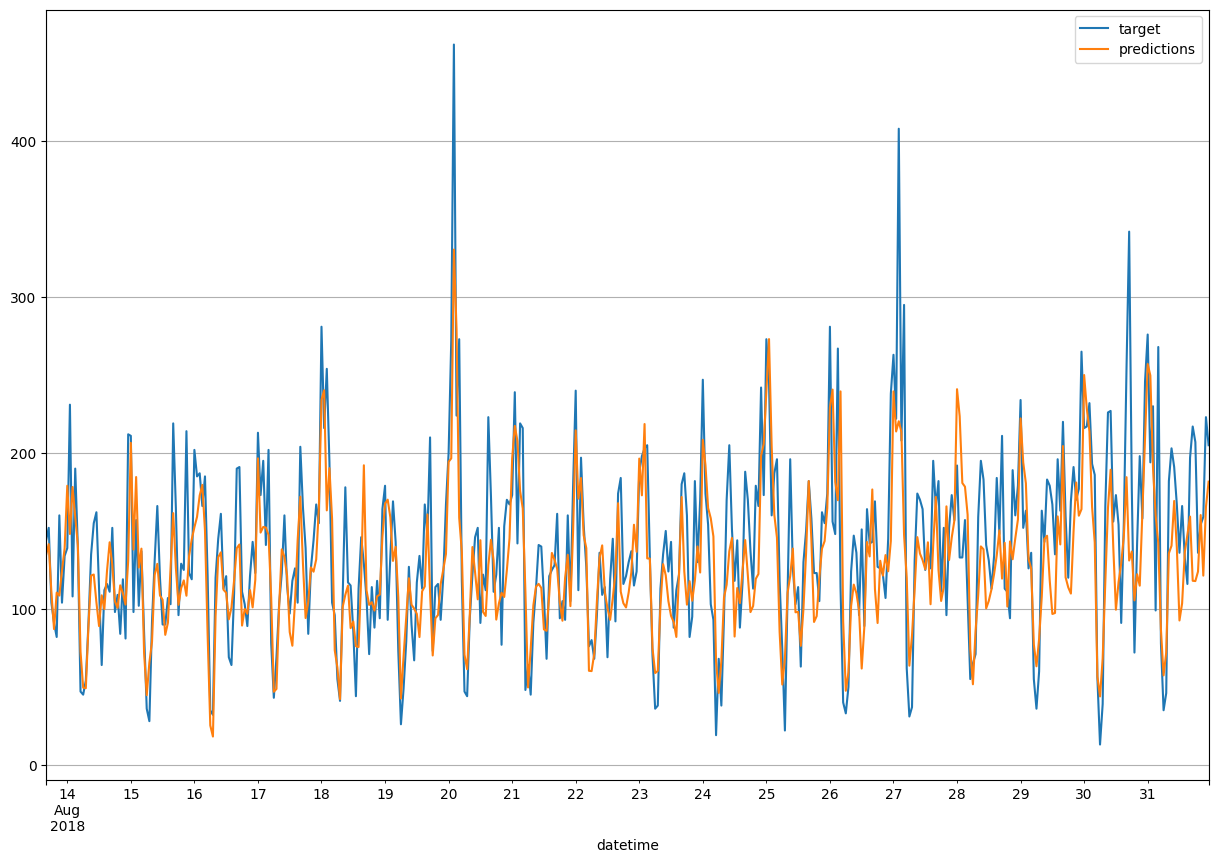

In [20]:
df_ftrs = make_features(df, 1, 24)
# разбивка на обучающую и тестовую выборки
train, test = train_test_split(df_ftrs,shuffle=False, test_size=0.1)
# Выделение признаков и целевого признака
features_train = train.drop('num_orders',axis=1) 
target_train = train['num_orders']
features_test = test.drop('num_orders',axis=1) 
target_test = test['num_orders']

random.best_estimator_.fit(features_train, target_train)


plt.figure(figsize=(15,10))
target_test.plot(ax=plt.gca(),label='target', legend=True)
pd.Series(random.best_estimator_.predict(features_test),index=target_test.index).plot(ax=plt.gca(),label='predictions', legend=True, grid=True)

### Вывод
Подобраны гиперпараметры модели CatBoostRegressor, лучшее качество достигается при 'n_estimators': 50, 'max_depth': 4, подобраны признаки максимизирующие качество: длина скользящего среднего **24**, максимальная задержка - 1 (увеличение не влияет на качество). RMSE модели на тестовой выборке составила 40,5** заказов в час. Визуально модель хорошо описывает основные тенденции, но часть выбросов пропускает.

## Общий вывод

1. Данные загружены и ресемплированы с шагом в 1 час.
2. Проанализированы тренд и сезонность ряда. наблюдаются растущий тренд и внутрисуточная сезонность. 
3. Созданы признаки, обучены модели, проверено их качество, сопоставлены с констанной и повторяющей предыдущее значение моделями. Лучшее качество cv_RMSE=25.62 у модели CatBoostRegressor (на тестовой выборке 45).
4. Подобраны гиперпараметры модели CatBoostRegressor, лучшее качество достигается при 'n_estimators': 50, 'max_depth': 4, подобраны признаки максимизирующие качество: длина скользящего среднего 24, максимальная задержка - 1 (увеличение задержки не влияет на качество). RMSE модели на тестовой выборке составила 40,5** заказов в час. Визуально модель хорошо описывает основные тенденции, но часть выбросов пропускает.